In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd

In [3]:
df = pd.read_csv("/kaggle/input/timmmm/task1_20k.csv") #Training data

**Preprocessing**

In [4]:
#Classifying into 7 buckets
li = []
for i in range(len(df)):
    if(df['likes'][i]<=10):
        li.append(0)
    elif(df['likes'][i]<=100):
        li.append(1)
    elif(df['likes'][i]<=300):
        li.append(2)
    elif(df['likes'][i]<=500):
        li.append(3)
    elif(df['likes'][i]<=1000):
        li.append(4)
    elif(df['likes'][i]<=2500):
        li.append(5)
    else:
        li.append(6)

In [5]:
df['bucket']  = li

In [6]:
df['bucket'] = df['bucket'].astype("object")

In [7]:
df['text'][0]

'Following is the information about Twitter post.Caption for Image of post: a flyer for tim hortons with an image of a sandwich and coffee, Text content: Spend your weekend morning with a Ham, Egg, and Cheese Wrap paired with a sweet Iced French Vanilla! ☀️ Order yours now via dine-in, takeout, and delivery. #TimHortonsPH <hyperlink>, Inferred company: tim hortons, Username: TimHortonsPH, Date and time: 2020-12-12 00:47:00, '

In [8]:
df

,Unnamed: 0,text,likes,id,bucket
0,0,Following is the information about Twitter pos...,1,1,0
1,1,Following is the information about Twitter pos...,2750,2,6
2,2,Following is the information about Twitter pos...,57,3,1
3,3,Following is the information about Twitter pos...,152,4,2
4,4,Following is the information about Twitter pos...,41,5,1
...,...,...,...,...,...
19994,19994,Following is the information about Twitter pos...,0,19995,0
19995,19995,Following is the information about Twitter pos...,132,19996,2
19996,19996,Following is the information about Twitter pos...,747,19997,4
19997,19997,Following is the information about Twitter pos...,0,19998,0


In [9]:
df['bucket'].value_counts()

bucket
0    6623
1    4474
2    3524
4    1816
5    1450
3    1068
6    1044
Name: count, dtype: int64

In [10]:
l = []
for i in range(len(df)):
    if(df['bucket'][i]==6):
        l.append(1)
    else:
        l.append(0)


In [11]:
s = pd.get_dummies(df['bucket'],dtype = np.int32)

In [12]:
df = pd.concat([df,s],axis = 1)

In [13]:
df = df.drop(['bucket','likes','Unnamed: 0'],axis =1)

In [14]:
ids = df['id']
df = df.drop(['id'],axis=1)

In [15]:
df

,text,0,1,2,3,4,5,6
0,Following is the information about Twitter pos...,1,0,0,0,0,0,0
1,Following is the information about Twitter pos...,0,0,0,0,0,0,1
2,Following is the information about Twitter pos...,0,1,0,0,0,0,0
3,Following is the information about Twitter pos...,0,0,1,0,0,0,0
4,Following is the information about Twitter pos...,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...
19994,Following is the information about Twitter pos...,1,0,0,0,0,0,0
19995,Following is the information about Twitter pos...,0,0,1,0,0,0,0
19996,Following is the information about Twitter pos...,0,0,0,0,1,0,0
19997,Following is the information about Twitter pos...,1,0,0,0,0,0,0


In [52]:
train_df =df[:18000]
val = df[19000:]
val = val.reset_index(drop =True)

In [53]:
train_df

,text,0,1,2,3,4,5,6
0,Following is the information about Twitter pos...,1,0,0,0,0,0,0
1,Following is the information about Twitter pos...,0,0,0,0,0,0,1
2,Following is the information about Twitter pos...,0,1,0,0,0,0,0
3,Following is the information about Twitter pos...,0,0,1,0,0,0,0
4,Following is the information about Twitter pos...,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...
17995,Following is the information about Twitter pos...,0,0,0,0,0,1,0
17996,Following is the information about Twitter pos...,0,0,1,0,0,0,0
17997,Following is the information about Twitter pos...,0,0,0,0,0,1,0
17998,Following is the information about Twitter pos...,0,1,0,0,0,0,0


In [54]:
labels = [0,1,2,3,4,5,6]

In [55]:
def clean(text):
    text = text.replace("<hyperlink>","").replace("<mention>","")
    return text

In [56]:
train_df['text'] = train_df['text'].apply(lambda x:clean(x))
val['text'] = val['text'].apply(lambda x:clean(x))

In [57]:
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel
from transformers import AutoTokenizer, AutoModel


In [58]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [59]:
from transformers import AutoTokenizer, AutoModel

In [60]:
x_train =train_df.iloc[:,0]
y_train = train_df.iloc[:,1:]
x_test = val.iloc[:,0]
y_test = val.iloc[:,1:]

In [61]:
X_train = pd.DataFrame()
X_train['text'] = x_train
X_test = pd.DataFrame()
X_test['text'] = x_test

In [62]:
from transformers import DistilBertTokenizer
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

# Using Pretrained DistilBertTokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Creating Dataset class for Toxic comments and Labels 
class Toxic_Dataset(Dataset):
    def __init__(self, Comments_, Labels_):
        self.comments = Comments_.copy()
        self.labels = Labels_.copy()
        
        self.comments["text"] = self.comments["text"].map(lambda x: tokenizer(x, padding="max_length", truncation=True, return_tensors="pt"))
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        comment = self.comments.loc[idx,"text"]
        label = np.array(self.labels.loc[idx,:])
        
        return comment, label

In [63]:
# Making Training, Testing and Validation of data using Dataset class
Train_data = Toxic_Dataset(X_train, y_train)
Test_data = Toxic_Dataset(X_test, y_test)
Val_data = Toxic_Dataset(X_test, y_test)

# Making datasets into batches 
Train_Loader = DataLoader(Train_data, batch_size=16, shuffle=True)
Test_Loader = DataLoader(Test_data, shuffle=False)        #batch_size=16, 
Val_Loader = DataLoader(Val_data, shuffle=False) 

In [64]:
from transformers import DistilBertForSequenceClassification

Distil_bert = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

Distil_bert.classifier = nn.Sequential(
    nn.Linear(768, 7),
    nn.Softmax(dim=1)
)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**Training**

In [66]:
from torch.optim import Adam
from tqdm import tqdm
from torch.nn import BCELoss,NLLLoss,CrossEntropyLoss
from torch.optim.lr_scheduler import StepLR

def train_Model(model,Train_DL, Val_DL, learning_rate, epochs):
    
    #device = 'cpu'
    
    Loss = CrossEntropyLoss()
    #Loss = NLLLoss()
    Optimizer = Adam(params=model.parameters(), lr=learning_rate)
    scheduler = StepLR(Optimizer, step_size=212, gamma=0.1)
    
    model.to(device)
    model.train()
    
    train_acc_epochs = []
    train_loss_epochs = []
    val_acc_epochs = []
    val_loss_epochs = []
    
    for epoch in range(epochs):
        training_loss = {}
        training_accuracy = {}
        validation_loss = {}
        validation_accuracy = {}
        batch = 0
        
        for comments, labels in tqdm(Train_DL):
            
            labels = labels.to(device)
            labels = labels.float()
            masks = comments["attention_mask"].squeeze(1).to(device) # the model used these masks to attend only to the non-padded tokens in the sequence
            input_ids = comments["input_ids"].squeeze(1).to(device) # contains the tokenized and indexed representation for a batch of comments
            # squeeze is used to remove the second dimension which has size 1.
            output = model(input_ids, masks)
            #labels = torch.argmax(labels, dim=1)
            #loss = Loss(output.logits, labels)
            k = (output.logits).float()# vector of logits for each class
            loss = Loss(k, labels) # compute the loss
            
            Optimizer.zero_grad()
            loss.backward()
            Optimizer.step()
            scheduler.step()

            
            batch += 1 
            if batch%10 == 0:
                with torch.no_grad():
                    acc = []
                    op = output.logits
                    #print(op)
                    for lb in range(len(labels)): # note: labels is of shape (batch_size, num_classes(=7))
                        correct = 0
                        idx = torch.argmax(op[lb])
                        if(labels[lb,idx]==1):
                            correct =1
                        
                        acc.append(correct)
#                     for lb in range(len(labels)): # note: labels is of shape (batch_size, num_classes(=7))
#                         correct = 0
#                         idx = torch.argmax(op[lb])
#                         if(idx == labels[lb]):
#                             correct =1
                        
#                         acc.append(correct)

                    training_loss[batch] = loss.item()
                    training_accuracy[batch] = sum(acc)/len(acc)
                    print(f"Epoch:{epoch+1} | batch no:{batch}/{len(Train_DL)} | Loss:{loss.item():.4f} | Accuracy:{sum(acc)/len(acc):.4f}")
        
                    # Testing model on validation Data
                    accVal = []
                    val_loss = 0
                    for comments, label in Val_DL:
                        label = label.to(device)
                        label = label.float()
                        masks = comments["attention_mask"].squeeze(1).to(device)
                        input_ids = comments["input_ids"].squeeze(1).to(device)
    
                        output = model(input_ids, masks)
                        #label = torch.argmax(label, dim=1)
                        loss = Loss(output.logits, label)
            
                        val_loss += loss.item()
            
                        op = output.logits
                        correct_val = 0
                        for lb in range(len(label)): # note: labels is of shape (batch_size, num_classes(=7))
                            correct_val = 0
                            idx = torch.argmax(op[lb])
                            if(label[lb,idx]==1):
                                correct_val =1
                        
                                #print(lb,idx,torch.argmax(label[lb]))
                            accVal.append(correct_val)
#                         for lb in range(len(label)):
#                             correct_val = 0
#                             idx = torch.argmax(op[lb])
#                             if(idx == label[lb]):
#                                 correct_val =1
                        
#                                 #print(lb,idx,torch.argmax(label[lb]))
#                             accVal.append(correct_val)
                    
                    validation_loss[batch] = val_loss/len(Val_DL)
                    validation_accuracy[batch] = sum(accVal)/len(accVal)
                    print(f" Validation Loss:{val_loss/len(Val_DL):.4f} | Validation Accuracy:{sum(accVal)/len(accVal):.4f}")
            
        train_acc_epochs.append(training_accuracy)
        train_loss_epochs.append(training_loss)
        val_acc_epochs.append(validation_accuracy)
        val_loss_epochs.append(validation_loss)
    torch.save(model.state_dict(), 'model_state_dict.pth')
    return train_acc_epochs, train_loss_epochs, val_acc_epochs, val_loss_epochs

In [67]:
TA, TL, VA, VL = train_Model(Distil_bert, Train_Loader, Val_Loader, learning_rate=0.0001, epochs=1)

  1%|          | 9/1125 [00:03<07:45,  2.40it/s]

Epoch:1 | batch no:10/1125 | Loss:1.8712 | Accuracy:0.3125


  1%|          | 10/1125 [00:15<1:12:15,  3.89s/it]

 Validation Loss:1.8262 | Validation Accuracy:0.3483


  2%|▏         | 19/1125 [00:19<10:11,  1.81it/s]  

Epoch:1 | batch no:20/1125 | Loss:1.7435 | Accuracy:0.4375


  2%|▏         | 20/1125 [00:30<1:11:38,  3.89s/it]

 Validation Loss:1.8183 | Validation Accuracy:0.3483


  3%|▎         | 29/1125 [00:34<10:09,  1.80it/s]  

Epoch:1 | batch no:30/1125 | Loss:1.8566 | Accuracy:0.3125


  3%|▎         | 30/1125 [00:46<1:10:56,  3.89s/it]

 Validation Loss:1.8155 | Validation Accuracy:0.3483


  3%|▎         | 39/1125 [00:49<10:05,  1.79it/s]  

Epoch:1 | batch no:40/1125 | Loss:1.8927 | Accuracy:0.2500


  4%|▎         | 40/1125 [01:01<1:10:17,  3.89s/it]

 Validation Loss:1.8132 | Validation Accuracy:0.3483


  4%|▍         | 49/1125 [01:05<09:59,  1.79it/s]  

Epoch:1 | batch no:50/1125 | Loss:1.7613 | Accuracy:0.4375


  4%|▍         | 50/1125 [01:17<1:09:37,  3.89s/it]

 Validation Loss:1.8104 | Validation Accuracy:0.3644


  5%|▌         | 59/1125 [01:20<09:54,  1.79it/s]  

Epoch:1 | batch no:60/1125 | Loss:1.7705 | Accuracy:0.4375


  5%|▌         | 60/1125 [01:32<1:08:59,  3.89s/it]

 Validation Loss:1.7180 | Validation Accuracy:0.4715


  6%|▌         | 69/1125 [01:36<09:51,  1.79it/s]  

Epoch:1 | batch no:70/1125 | Loss:1.9417 | Accuracy:0.1875


  6%|▌         | 70/1125 [01:47<1:08:26,  3.89s/it]

 Validation Loss:1.7031 | Validation Accuracy:0.4575


  7%|▋         | 79/1125 [01:51<09:47,  1.78it/s]  

Epoch:1 | batch no:80/1125 | Loss:1.6391 | Accuracy:0.5000


  7%|▋         | 80/1125 [02:03<1:07:41,  3.89s/it]

 Validation Loss:1.7229 | Validation Accuracy:0.4494


  8%|▊         | 89/1125 [02:07<09:44,  1.77it/s]  

Epoch:1 | batch no:90/1125 | Loss:1.7379 | Accuracy:0.4375


  8%|▊         | 90/1125 [02:18<1:07:11,  3.90s/it]

 Validation Loss:1.6562 | Validation Accuracy:0.4975


  9%|▉         | 99/1125 [02:22<09:42,  1.76it/s]  

Epoch:1 | batch no:100/1125 | Loss:1.8212 | Accuracy:0.3125


  9%|▉         | 100/1125 [02:34<1:06:28,  3.89s/it]

 Validation Loss:1.6503 | Validation Accuracy:0.4925


 10%|▉         | 109/1125 [02:38<09:31,  1.78it/s]  

Epoch:1 | batch no:110/1125 | Loss:1.6534 | Accuracy:0.5000


 10%|▉         | 110/1125 [02:49<1:05:53,  3.90s/it]

 Validation Loss:1.6323 | Validation Accuracy:0.5516


 11%|█         | 119/1125 [02:53<09:30,  1.76it/s]  

Epoch:1 | batch no:120/1125 | Loss:1.4303 | Accuracy:0.7500


 11%|█         | 120/1125 [03:05<1:05:17,  3.90s/it]

 Validation Loss:1.6392 | Validation Accuracy:0.5225


 11%|█▏        | 129/1125 [03:09<09:25,  1.76it/s]  

Epoch:1 | batch no:130/1125 | Loss:1.9353 | Accuracy:0.1875


 12%|█▏        | 130/1125 [03:20<1:04:35,  3.90s/it]

 Validation Loss:1.7498 | Validation Accuracy:0.4064


 12%|█▏        | 139/1125 [03:24<09:19,  1.76it/s]  

Epoch:1 | batch no:140/1125 | Loss:1.6865 | Accuracy:0.4375
 Validation Loss:1.6589 | Validation Accuracy:0.4985


 13%|█▎        | 149/1125 [03:40<09:09,  1.78it/s]  

Epoch:1 | batch no:150/1125 | Loss:1.9307 | Accuracy:0.1875


 13%|█▎        | 150/1125 [03:51<1:03:20,  3.90s/it]

 Validation Loss:1.6861 | Validation Accuracy:0.4745


 14%|█▍        | 159/1125 [03:55<09:04,  1.77it/s]  

Epoch:1 | batch no:160/1125 | Loss:1.5994 | Accuracy:0.5625


 14%|█▍        | 160/1125 [04:07<1:02:42,  3.90s/it]

 Validation Loss:1.6466 | Validation Accuracy:0.5085


 15%|█▌        | 169/1125 [04:11<09:02,  1.76it/s]  

Epoch:1 | batch no:170/1125 | Loss:1.5788 | Accuracy:0.6250


 15%|█▌        | 170/1125 [04:22<1:02:03,  3.90s/it]

 Validation Loss:1.6544 | Validation Accuracy:0.5025


 16%|█▌        | 179/1125 [04:26<08:56,  1.76it/s]  

Epoch:1 | batch no:180/1125 | Loss:1.7216 | Accuracy:0.4375


 16%|█▌        | 180/1125 [04:38<1:01:22,  3.90s/it]

 Validation Loss:1.6515 | Validation Accuracy:0.5095


 17%|█▋        | 189/1125 [04:42<08:46,  1.78it/s]  

Epoch:1 | batch no:190/1125 | Loss:1.7216 | Accuracy:0.4375


 17%|█▋        | 190/1125 [04:53<1:00:44,  3.90s/it]

 Validation Loss:1.6603 | Validation Accuracy:0.5035


 18%|█▊        | 199/1125 [04:57<08:42,  1.77it/s]  

Epoch:1 | batch no:200/1125 | Loss:1.6822 | Accuracy:0.5000


 18%|█▊        | 200/1125 [05:09<1:00:01,  3.89s/it]

 Validation Loss:1.6308 | Validation Accuracy:0.5285


 19%|█▊        | 209/1125 [05:13<08:38,  1.77it/s]  

Epoch:1 | batch no:210/1125 | Loss:1.4656 | Accuracy:0.6875


 19%|█▊        | 210/1125 [05:24<59:26,  3.90s/it]

 Validation Loss:1.6148 | Validation Accuracy:0.5536


 19%|█▉        | 219/1125 [05:28<08:34,  1.76it/s]

Epoch:1 | batch no:220/1125 | Loss:1.2724 | Accuracy:0.9375


 20%|█▉        | 220/1125 [05:40<58:44,  3.89s/it]

 Validation Loss:1.6100 | Validation Accuracy:0.5536


 20%|██        | 229/1125 [05:44<08:26,  1.77it/s]

Epoch:1 | batch no:230/1125 | Loss:1.4860 | Accuracy:0.6875


 20%|██        | 230/1125 [05:55<58:08,  3.90s/it]

 Validation Loss:1.6145 | Validation Accuracy:0.5485


 21%|██        | 239/1125 [05:59<08:21,  1.77it/s]

Epoch:1 | batch no:240/1125 | Loss:1.5784 | Accuracy:0.5625


 21%|██▏       | 240/1125 [06:11<57:30,  3.90s/it]

 Validation Loss:1.6091 | Validation Accuracy:0.5526


 22%|██▏       | 249/1125 [06:15<08:15,  1.77it/s]

Epoch:1 | batch no:250/1125 | Loss:1.5896 | Accuracy:0.5625


 22%|██▏       | 250/1125 [06:26<56:48,  3.90s/it]

 Validation Loss:1.6039 | Validation Accuracy:0.5616


 23%|██▎       | 259/1125 [06:30<08:09,  1.77it/s]

Epoch:1 | batch no:260/1125 | Loss:1.3763 | Accuracy:0.8125


 23%|██▎       | 260/1125 [06:42<56:08,  3.89s/it]

 Validation Loss:1.6062 | Validation Accuracy:0.5636


 24%|██▍       | 269/1125 [06:46<08:05,  1.76it/s]

Epoch:1 | batch no:270/1125 | Loss:1.6307 | Accuracy:0.5625


 24%|██▍       | 270/1125 [06:57<55:29,  3.89s/it]

 Validation Loss:1.6059 | Validation Accuracy:0.5626


 25%|██▍       | 279/1125 [07:01<07:58,  1.77it/s]

Epoch:1 | batch no:280/1125 | Loss:1.8666 | Accuracy:0.3125


 25%|██▍       | 280/1125 [07:13<54:48,  3.89s/it]

 Validation Loss:1.5877 | Validation Accuracy:0.5736


 26%|██▌       | 289/1125 [07:17<07:53,  1.77it/s]

Epoch:1 | batch no:290/1125 | Loss:1.4343 | Accuracy:0.7500


 26%|██▌       | 290/1125 [07:28<54:18,  3.90s/it]

 Validation Loss:1.5778 | Validation Accuracy:0.5866


 27%|██▋       | 299/1125 [07:32<07:46,  1.77it/s]

Epoch:1 | batch no:300/1125 | Loss:1.3272 | Accuracy:0.8750


 27%|██▋       | 300/1125 [07:44<53:34,  3.90s/it]

 Validation Loss:1.5776 | Validation Accuracy:0.5816


 27%|██▋       | 309/1125 [07:48<07:40,  1.77it/s]

Epoch:1 | batch no:310/1125 | Loss:1.5870 | Accuracy:0.5625


 28%|██▊       | 310/1125 [07:59<52:58,  3.90s/it]

 Validation Loss:1.5744 | Validation Accuracy:0.5856


 28%|██▊       | 319/1125 [08:03<07:37,  1.76it/s]

Epoch:1 | batch no:320/1125 | Loss:1.6408 | Accuracy:0.5625


 28%|██▊       | 320/1125 [08:15<52:12,  3.89s/it]

 Validation Loss:1.5717 | Validation Accuracy:0.5846


 29%|██▉       | 329/1125 [08:19<07:32,  1.76it/s]

Epoch:1 | batch no:330/1125 | Loss:1.5356 | Accuracy:0.6875


 29%|██▉       | 330/1125 [08:30<51:42,  3.90s/it]

 Validation Loss:1.5685 | Validation Accuracy:0.5926


 30%|███       | 339/1125 [08:34<07:25,  1.77it/s]

Epoch:1 | batch no:340/1125 | Loss:1.7223 | Accuracy:0.4375


 30%|███       | 340/1125 [08:46<51:00,  3.90s/it]

 Validation Loss:1.5692 | Validation Accuracy:0.5936


 31%|███       | 349/1125 [08:50<07:19,  1.77it/s]

Epoch:1 | batch no:350/1125 | Loss:1.4622 | Accuracy:0.6875


 31%|███       | 350/1125 [09:01<50:21,  3.90s/it]

 Validation Loss:1.5688 | Validation Accuracy:0.5946


 32%|███▏      | 359/1125 [09:05<07:13,  1.77it/s]

Epoch:1 | batch no:360/1125 | Loss:1.5498 | Accuracy:0.6250


 32%|███▏      | 360/1125 [09:17<49:45,  3.90s/it]

 Validation Loss:1.5720 | Validation Accuracy:0.5886


 33%|███▎      | 369/1125 [09:21<07:07,  1.77it/s]

Epoch:1 | batch no:370/1125 | Loss:1.6554 | Accuracy:0.5000


 33%|███▎      | 370/1125 [09:32<49:00,  3.89s/it]

 Validation Loss:1.5667 | Validation Accuracy:0.5976


 34%|███▎      | 379/1125 [09:36<07:03,  1.76it/s]

Epoch:1 | batch no:380/1125 | Loss:1.7450 | Accuracy:0.4375


 34%|███▍      | 380/1125 [09:48<48:25,  3.90s/it]

 Validation Loss:1.5694 | Validation Accuracy:0.5936


 35%|███▍      | 389/1125 [09:52<06:55,  1.77it/s]

Epoch:1 | batch no:390/1125 | Loss:1.4982 | Accuracy:0.6875


 35%|███▍      | 390/1125 [10:03<47:47,  3.90s/it]

 Validation Loss:1.5698 | Validation Accuracy:0.5926


 35%|███▌      | 399/1125 [10:07<06:52,  1.76it/s]

Epoch:1 | batch no:400/1125 | Loss:1.5428 | Accuracy:0.6250


 36%|███▌      | 400/1125 [10:19<47:04,  3.90s/it]

 Validation Loss:1.5702 | Validation Accuracy:0.5916


 36%|███▋      | 409/1125 [10:23<06:45,  1.77it/s]

Epoch:1 | batch no:410/1125 | Loss:1.6064 | Accuracy:0.5625


 36%|███▋      | 410/1125 [10:34<46:27,  3.90s/it]

 Validation Loss:1.5684 | Validation Accuracy:0.5986


 37%|███▋      | 419/1125 [10:38<06:40,  1.76it/s]

Epoch:1 | batch no:420/1125 | Loss:1.7641 | Accuracy:0.3750


 37%|███▋      | 420/1125 [10:50<45:45,  3.89s/it]

 Validation Loss:1.5689 | Validation Accuracy:0.5916


 38%|███▊      | 429/1125 [10:54<06:34,  1.76it/s]

Epoch:1 | batch no:430/1125 | Loss:1.5887 | Accuracy:0.5625


 38%|███▊      | 430/1125 [11:05<45:11,  3.90s/it]

 Validation Loss:1.5661 | Validation Accuracy:0.6006


 39%|███▉      | 439/1125 [11:09<06:29,  1.76it/s]

Epoch:1 | batch no:440/1125 | Loss:1.8333 | Accuracy:0.3125


 39%|███▉      | 440/1125 [11:21<44:30,  3.90s/it]

 Validation Loss:1.5659 | Validation Accuracy:0.5956


 40%|███▉      | 449/1125 [11:25<06:23,  1.76it/s]

Epoch:1 | batch no:450/1125 | Loss:1.5621 | Accuracy:0.6250


 40%|████      | 450/1125 [11:36<43:54,  3.90s/it]

 Validation Loss:1.5643 | Validation Accuracy:0.6036


 41%|████      | 459/1125 [11:40<06:16,  1.77it/s]

Epoch:1 | batch no:460/1125 | Loss:1.3849 | Accuracy:0.8125


 41%|████      | 460/1125 [11:52<43:11,  3.90s/it]

 Validation Loss:1.5625 | Validation Accuracy:0.6006


 42%|████▏     | 469/1125 [11:56<06:12,  1.76it/s]

Epoch:1 | batch no:470/1125 | Loss:1.4838 | Accuracy:0.6875


 42%|████▏     | 470/1125 [12:07<42:33,  3.90s/it]

 Validation Loss:1.5620 | Validation Accuracy:0.6026


 43%|████▎     | 479/1125 [12:11<06:05,  1.77it/s]

Epoch:1 | batch no:480/1125 | Loss:1.4741 | Accuracy:0.7500


 43%|████▎     | 480/1125 [12:23<41:51,  3.89s/it]

 Validation Loss:1.5679 | Validation Accuracy:0.6016


 43%|████▎     | 489/1125 [12:27<05:59,  1.77it/s]

Epoch:1 | batch no:490/1125 | Loss:1.5952 | Accuracy:0.5625


 44%|████▎     | 490/1125 [12:38<41:17,  3.90s/it]

 Validation Loss:1.5636 | Validation Accuracy:0.6056


 44%|████▍     | 499/1125 [12:42<05:54,  1.77it/s]

Epoch:1 | batch no:500/1125 | Loss:1.6007 | Accuracy:0.5625


 44%|████▍     | 500/1125 [12:54<40:34,  3.89s/it]

 Validation Loss:1.5607 | Validation Accuracy:0.6066


 45%|████▌     | 509/1125 [12:58<05:50,  1.76it/s]

Epoch:1 | batch no:510/1125 | Loss:1.5983 | Accuracy:0.5625


 45%|████▌     | 510/1125 [13:09<39:59,  3.90s/it]

 Validation Loss:1.5678 | Validation Accuracy:0.5956


 46%|████▌     | 519/1125 [13:13<05:43,  1.77it/s]

Epoch:1 | batch no:520/1125 | Loss:1.4931 | Accuracy:0.6875


 46%|████▌     | 520/1125 [13:25<39:16,  3.90s/it]

 Validation Loss:1.5642 | Validation Accuracy:0.6036


 47%|████▋     | 529/1125 [13:29<05:35,  1.78it/s]

Epoch:1 | batch no:530/1125 | Loss:1.5732 | Accuracy:0.5625


 47%|████▋     | 530/1125 [13:40<38:38,  3.90s/it]

 Validation Loss:1.5654 | Validation Accuracy:0.5986


 48%|████▊     | 539/1125 [13:44<05:32,  1.76it/s]

Epoch:1 | batch no:540/1125 | Loss:1.6011 | Accuracy:0.5625


 48%|████▊     | 540/1125 [13:56<37:58,  3.90s/it]

 Validation Loss:1.5613 | Validation Accuracy:0.6016


 49%|████▉     | 549/1125 [14:00<05:27,  1.76it/s]

Epoch:1 | batch no:550/1125 | Loss:1.8105 | Accuracy:0.3125


 49%|████▉     | 550/1125 [14:11<37:21,  3.90s/it]

 Validation Loss:1.5616 | Validation Accuracy:0.6016


 50%|████▉     | 559/1125 [14:15<05:19,  1.77it/s]

Epoch:1 | batch no:560/1125 | Loss:1.5251 | Accuracy:0.6250


 50%|████▉     | 560/1125 [14:27<36:42,  3.90s/it]

 Validation Loss:1.5583 | Validation Accuracy:0.6076


 51%|█████     | 569/1125 [14:31<05:14,  1.77it/s]

Epoch:1 | batch no:570/1125 | Loss:1.4823 | Accuracy:0.6875


 51%|█████     | 570/1125 [14:43<36:03,  3.90s/it]

 Validation Loss:1.5591 | Validation Accuracy:0.6086


 51%|█████▏    | 579/1125 [14:46<05:10,  1.76it/s]

Epoch:1 | batch no:580/1125 | Loss:1.5768 | Accuracy:0.5625


 52%|█████▏    | 580/1125 [14:58<35:22,  3.89s/it]

 Validation Loss:1.5611 | Validation Accuracy:0.6086


 52%|█████▏    | 589/1125 [15:02<05:03,  1.76it/s]

Epoch:1 | batch no:590/1125 | Loss:1.5044 | Accuracy:0.6875


 52%|█████▏    | 590/1125 [15:14<34:46,  3.90s/it]

 Validation Loss:1.5644 | Validation Accuracy:0.5976


 53%|█████▎    | 599/1125 [15:17<04:58,  1.76it/s]

Epoch:1 | batch no:600/1125 | Loss:1.6646 | Accuracy:0.5000


 53%|█████▎    | 600/1125 [15:29<34:08,  3.90s/it]

 Validation Loss:1.5589 | Validation Accuracy:0.6066


 54%|█████▍    | 609/1125 [15:33<04:51,  1.77it/s]

Epoch:1 | batch no:610/1125 | Loss:1.6929 | Accuracy:0.4375


 54%|█████▍    | 610/1125 [15:45<33:27,  3.90s/it]

 Validation Loss:1.5626 | Validation Accuracy:0.6026


 55%|█████▌    | 619/1125 [15:48<04:47,  1.76it/s]

Epoch:1 | batch no:620/1125 | Loss:1.5341 | Accuracy:0.6250


 55%|█████▌    | 620/1125 [16:00<32:48,  3.90s/it]

 Validation Loss:1.5584 | Validation Accuracy:0.6096


 56%|█████▌    | 629/1125 [16:04<04:39,  1.77it/s]

Epoch:1 | batch no:630/1125 | Loss:1.5506 | Accuracy:0.6250


 56%|█████▌    | 630/1125 [16:16<32:08,  3.90s/it]

 Validation Loss:1.5634 | Validation Accuracy:0.6026


 57%|█████▋    | 639/1125 [16:19<04:34,  1.77it/s]

Epoch:1 | batch no:640/1125 | Loss:1.5458 | Accuracy:0.5625


 57%|█████▋    | 640/1125 [16:31<31:29,  3.90s/it]

 Validation Loss:1.5614 | Validation Accuracy:0.5996


 58%|█████▊    | 649/1125 [16:35<04:30,  1.76it/s]

Epoch:1 | batch no:650/1125 | Loss:1.6370 | Accuracy:0.5000


 58%|█████▊    | 650/1125 [16:47<30:52,  3.90s/it]

 Validation Loss:1.5575 | Validation Accuracy:0.6066


 59%|█████▊    | 659/1125 [16:50<04:24,  1.76it/s]

Epoch:1 | batch no:660/1125 | Loss:1.6005 | Accuracy:0.5625


 59%|█████▊    | 660/1125 [17:02<30:12,  3.90s/it]

 Validation Loss:1.5563 | Validation Accuracy:0.6166


 59%|█████▉    | 669/1125 [17:06<04:19,  1.76it/s]

Epoch:1 | batch no:670/1125 | Loss:1.4889 | Accuracy:0.6875


 60%|█████▉    | 670/1125 [17:18<29:34,  3.90s/it]

 Validation Loss:1.5657 | Validation Accuracy:0.5976


 60%|██████    | 679/1125 [17:21<04:14,  1.75it/s]

Epoch:1 | batch no:680/1125 | Loss:1.5521 | Accuracy:0.6250
 Validation Loss:1.5558 | Validation Accuracy:0.6146


 61%|██████    | 689/1125 [17:37<04:05,  1.77it/s]

Epoch:1 | batch no:690/1125 | Loss:1.4008 | Accuracy:0.7500


 61%|██████▏   | 690/1125 [17:49<28:16,  3.90s/it]

 Validation Loss:1.5609 | Validation Accuracy:0.6066


 62%|██████▏   | 699/1125 [17:52<04:01,  1.76it/s]

Epoch:1 | batch no:700/1125 | Loss:1.7720 | Accuracy:0.3750


 62%|██████▏   | 700/1125 [18:04<27:37,  3.90s/it]

 Validation Loss:1.5633 | Validation Accuracy:0.6026


 63%|██████▎   | 709/1125 [18:08<03:56,  1.76it/s]

Epoch:1 | batch no:710/1125 | Loss:1.5573 | Accuracy:0.6250


 63%|██████▎   | 710/1125 [18:20<26:57,  3.90s/it]

 Validation Loss:1.5587 | Validation Accuracy:0.6066


 64%|██████▍   | 719/1125 [18:24<03:50,  1.76it/s]

Epoch:1 | batch no:720/1125 | Loss:1.5241 | Accuracy:0.6250


 64%|██████▍   | 720/1125 [18:35<26:17,  3.89s/it]

 Validation Loss:1.5591 | Validation Accuracy:0.6096


 65%|██████▍   | 729/1125 [18:39<03:44,  1.76it/s]

Epoch:1 | batch no:730/1125 | Loss:1.5145 | Accuracy:0.6250


 65%|██████▍   | 730/1125 [18:51<25:39,  3.90s/it]

 Validation Loss:1.5601 | Validation Accuracy:0.6076


 66%|██████▌   | 739/1125 [18:55<03:38,  1.77it/s]

Epoch:1 | batch no:740/1125 | Loss:1.6628 | Accuracy:0.5000


 66%|██████▌   | 740/1125 [19:06<25:00,  3.90s/it]

 Validation Loss:1.5623 | Validation Accuracy:0.6006


 67%|██████▋   | 749/1125 [19:10<03:33,  1.76it/s]

Epoch:1 | batch no:750/1125 | Loss:1.5030 | Accuracy:0.6875


 67%|██████▋   | 750/1125 [19:22<24:26,  3.91s/it]

 Validation Loss:1.5540 | Validation Accuracy:0.6146


 67%|██████▋   | 759/1125 [19:26<03:28,  1.76it/s]

Epoch:1 | batch no:760/1125 | Loss:1.4511 | Accuracy:0.7500


 68%|██████▊   | 760/1125 [19:37<23:44,  3.90s/it]

 Validation Loss:1.5572 | Validation Accuracy:0.6086


 68%|██████▊   | 769/1125 [19:41<03:21,  1.76it/s]

Epoch:1 | batch no:770/1125 | Loss:1.4936 | Accuracy:0.6875


 68%|██████▊   | 770/1125 [19:53<23:04,  3.90s/it]

 Validation Loss:1.5572 | Validation Accuracy:0.6136


 69%|██████▉   | 779/1125 [19:57<03:15,  1.77it/s]

Epoch:1 | batch no:780/1125 | Loss:1.5417 | Accuracy:0.6250


 69%|██████▉   | 780/1125 [20:08<22:24,  3.90s/it]

 Validation Loss:1.5616 | Validation Accuracy:0.6036


 70%|███████   | 789/1125 [20:12<03:09,  1.77it/s]

Epoch:1 | batch no:790/1125 | Loss:1.4878 | Accuracy:0.6875


 70%|███████   | 790/1125 [20:24<21:45,  3.90s/it]

 Validation Loss:1.5577 | Validation Accuracy:0.6076


 71%|███████   | 799/1125 [20:28<03:05,  1.76it/s]

Epoch:1 | batch no:800/1125 | Loss:1.5975 | Accuracy:0.5625


 71%|███████   | 800/1125 [20:39<21:08,  3.90s/it]

 Validation Loss:1.5604 | Validation Accuracy:0.6076


 72%|███████▏  | 809/1125 [20:43<02:58,  1.77it/s]

Epoch:1 | batch no:810/1125 | Loss:1.6002 | Accuracy:0.5625


 72%|███████▏  | 810/1125 [20:55<20:27,  3.90s/it]

 Validation Loss:1.5617 | Validation Accuracy:0.6006


 73%|███████▎  | 819/1125 [20:59<02:53,  1.76it/s]

Epoch:1 | batch no:820/1125 | Loss:1.4570 | Accuracy:0.6875


 73%|███████▎  | 820/1125 [21:10<19:49,  3.90s/it]

 Validation Loss:1.5635 | Validation Accuracy:0.6016


 74%|███████▎  | 829/1125 [21:14<02:48,  1.76it/s]

Epoch:1 | batch no:830/1125 | Loss:1.4296 | Accuracy:0.6875


 74%|███████▍  | 830/1125 [21:26<19:11,  3.90s/it]

 Validation Loss:1.5566 | Validation Accuracy:0.6116


 75%|███████▍  | 839/1125 [21:30<02:42,  1.76it/s]

Epoch:1 | batch no:840/1125 | Loss:1.7147 | Accuracy:0.5000


 75%|███████▍  | 840/1125 [21:41<18:31,  3.90s/it]

 Validation Loss:1.5589 | Validation Accuracy:0.6096


 75%|███████▌  | 849/1125 [21:45<02:35,  1.77it/s]

Epoch:1 | batch no:850/1125 | Loss:1.5648 | Accuracy:0.6250


 76%|███████▌  | 850/1125 [21:57<17:51,  3.90s/it]

 Validation Loss:1.5586 | Validation Accuracy:0.6046


 76%|███████▋  | 859/1125 [22:01<02:30,  1.76it/s]

Epoch:1 | batch no:860/1125 | Loss:1.7002 | Accuracy:0.4375


 76%|███████▋  | 860/1125 [22:12<17:14,  3.90s/it]

 Validation Loss:1.5550 | Validation Accuracy:0.6126


 77%|███████▋  | 869/1125 [22:16<02:25,  1.76it/s]

Epoch:1 | batch no:870/1125 | Loss:1.4962 | Accuracy:0.6875


 77%|███████▋  | 870/1125 [22:28<16:35,  3.90s/it]

 Validation Loss:1.5603 | Validation Accuracy:0.6096


 78%|███████▊  | 879/1125 [22:32<02:19,  1.77it/s]

Epoch:1 | batch no:880/1125 | Loss:1.5355 | Accuracy:0.6250


 78%|███████▊  | 880/1125 [22:43<15:56,  3.90s/it]

 Validation Loss:1.5592 | Validation Accuracy:0.6066


 79%|███████▉  | 889/1125 [22:47<02:13,  1.76it/s]

Epoch:1 | batch no:890/1125 | Loss:1.6472 | Accuracy:0.5000


 79%|███████▉  | 890/1125 [22:59<15:16,  3.90s/it]

 Validation Loss:1.5619 | Validation Accuracy:0.6026


 80%|███████▉  | 899/1125 [23:03<02:08,  1.77it/s]

Epoch:1 | batch no:900/1125 | Loss:1.6646 | Accuracy:0.5000


 80%|████████  | 900/1125 [23:14<14:37,  3.90s/it]

 Validation Loss:1.5563 | Validation Accuracy:0.6146


 81%|████████  | 909/1125 [23:18<02:02,  1.76it/s]

Epoch:1 | batch no:910/1125 | Loss:1.5261 | Accuracy:0.6250


 81%|████████  | 910/1125 [23:30<13:59,  3.90s/it]

 Validation Loss:1.5597 | Validation Accuracy:0.6036


 82%|████████▏ | 919/1125 [23:34<01:56,  1.77it/s]

Epoch:1 | batch no:920/1125 | Loss:1.4461 | Accuracy:0.7500


 82%|████████▏ | 920/1125 [23:46<13:19,  3.90s/it]

 Validation Loss:1.5582 | Validation Accuracy:0.6076


 83%|████████▎ | 929/1125 [23:49<01:51,  1.76it/s]

Epoch:1 | batch no:930/1125 | Loss:1.5670 | Accuracy:0.6250


 83%|████████▎ | 930/1125 [24:01<12:41,  3.91s/it]

 Validation Loss:1.5542 | Validation Accuracy:0.6136


 83%|████████▎ | 939/1125 [24:05<01:45,  1.76it/s]

Epoch:1 | batch no:940/1125 | Loss:1.6008 | Accuracy:0.5625


 84%|████████▎ | 940/1125 [24:17<12:02,  3.91s/it]

 Validation Loss:1.5577 | Validation Accuracy:0.6086


 84%|████████▍ | 949/1125 [24:20<01:40,  1.76it/s]

Epoch:1 | batch no:950/1125 | Loss:1.6603 | Accuracy:0.5000


 84%|████████▍ | 950/1125 [24:32<11:22,  3.90s/it]

 Validation Loss:1.5585 | Validation Accuracy:0.6066


 85%|████████▌ | 959/1125 [24:36<01:34,  1.76it/s]

Epoch:1 | batch no:960/1125 | Loss:1.5412 | Accuracy:0.6250


 85%|████████▌ | 960/1125 [24:48<10:44,  3.91s/it]

 Validation Loss:1.5573 | Validation Accuracy:0.6066


 86%|████████▌ | 969/1125 [24:51<01:28,  1.76it/s]

Epoch:1 | batch no:970/1125 | Loss:1.4265 | Accuracy:0.7500


 86%|████████▌ | 970/1125 [25:03<10:04,  3.90s/it]

 Validation Loss:1.5596 | Validation Accuracy:0.6016


 87%|████████▋ | 979/1125 [25:07<01:22,  1.77it/s]

Epoch:1 | batch no:980/1125 | Loss:1.3551 | Accuracy:0.8125


 87%|████████▋ | 980/1125 [25:19<09:25,  3.90s/it]

 Validation Loss:1.5596 | Validation Accuracy:0.6066


 88%|████████▊ | 989/1125 [25:23<01:17,  1.76it/s]

Epoch:1 | batch no:990/1125 | Loss:1.8024 | Accuracy:0.3125


 88%|████████▊ | 990/1125 [25:34<08:46,  3.90s/it]

 Validation Loss:1.5619 | Validation Accuracy:0.6046


 89%|████████▉ | 999/1125 [25:38<01:11,  1.77it/s]

Epoch:1 | batch no:1000/1125 | Loss:1.4749 | Accuracy:0.6875


 89%|████████▉ | 1000/1125 [25:50<08:07,  3.90s/it]

 Validation Loss:1.5568 | Validation Accuracy:0.6106


 90%|████████▉ | 1009/1125 [25:54<01:05,  1.77it/s]

Epoch:1 | batch no:1010/1125 | Loss:1.6458 | Accuracy:0.5625


 90%|████████▉ | 1010/1125 [26:05<07:28,  3.90s/it]

 Validation Loss:1.5576 | Validation Accuracy:0.6056


 91%|█████████ | 1019/1125 [26:09<01:00,  1.76it/s]

Epoch:1 | batch no:1020/1125 | Loss:1.4458 | Accuracy:0.7500


 91%|█████████ | 1020/1125 [26:21<06:49,  3.90s/it]

 Validation Loss:1.5596 | Validation Accuracy:0.6076


 91%|█████████▏| 1029/1125 [26:25<00:54,  1.76it/s]

Epoch:1 | batch no:1030/1125 | Loss:1.5976 | Accuracy:0.5625


 92%|█████████▏| 1030/1125 [26:36<06:10,  3.90s/it]

 Validation Loss:1.5587 | Validation Accuracy:0.6066


 92%|█████████▏| 1039/1125 [26:40<00:48,  1.76it/s]

Epoch:1 | batch no:1040/1125 | Loss:1.4460 | Accuracy:0.6875


 92%|█████████▏| 1040/1125 [26:52<05:31,  3.90s/it]

 Validation Loss:1.5613 | Validation Accuracy:0.6056


 93%|█████████▎| 1049/1125 [26:56<00:43,  1.76it/s]

Epoch:1 | batch no:1050/1125 | Loss:1.5145 | Accuracy:0.6875


 93%|█████████▎| 1050/1125 [27:07<04:52,  3.90s/it]

 Validation Loss:1.5578 | Validation Accuracy:0.6086


 94%|█████████▍| 1059/1125 [27:11<00:37,  1.77it/s]

Epoch:1 | batch no:1060/1125 | Loss:1.4110 | Accuracy:0.7500


 94%|█████████▍| 1060/1125 [27:23<04:13,  3.90s/it]

 Validation Loss:1.5601 | Validation Accuracy:0.6076


 95%|█████████▌| 1069/1125 [27:27<00:31,  1.76it/s]

Epoch:1 | batch no:1070/1125 | Loss:1.5988 | Accuracy:0.5625


 95%|█████████▌| 1070/1125 [27:38<03:34,  3.90s/it]

 Validation Loss:1.5587 | Validation Accuracy:0.6126


 96%|█████████▌| 1079/1125 [27:42<00:26,  1.77it/s]

Epoch:1 | batch no:1080/1125 | Loss:1.4636 | Accuracy:0.6875


 96%|█████████▌| 1080/1125 [27:54<02:55,  3.91s/it]

 Validation Loss:1.5615 | Validation Accuracy:0.6036


 97%|█████████▋| 1089/1125 [27:58<00:20,  1.76it/s]

Epoch:1 | batch no:1090/1125 | Loss:1.5250 | Accuracy:0.6250


 97%|█████████▋| 1090/1125 [28:09<02:16,  3.91s/it]

 Validation Loss:1.5568 | Validation Accuracy:0.6116


 98%|█████████▊| 1099/1125 [28:13<00:14,  1.76it/s]

Epoch:1 | batch no:1100/1125 | Loss:1.4465 | Accuracy:0.7500


 98%|█████████▊| 1100/1125 [28:25<01:37,  3.90s/it]

 Validation Loss:1.5580 | Validation Accuracy:0.6076


 99%|█████████▊| 1109/1125 [28:29<00:09,  1.77it/s]

Epoch:1 | batch no:1110/1125 | Loss:1.6102 | Accuracy:0.5000


 99%|█████████▊| 1110/1125 [28:40<00:58,  3.90s/it]

 Validation Loss:1.5580 | Validation Accuracy:0.6036


 99%|█████████▉| 1119/1125 [28:44<00:03,  1.76it/s]

Epoch:1 | batch no:1120/1125 | Loss:1.4496 | Accuracy:0.6875


100%|█████████▉| 1120/1125 [28:56<00:19,  3.91s/it]

 Validation Loss:1.5583 | Validation Accuracy:0.6036


100%|██████████| 1125/1125 [28:58<00:00,  1.55s/it]


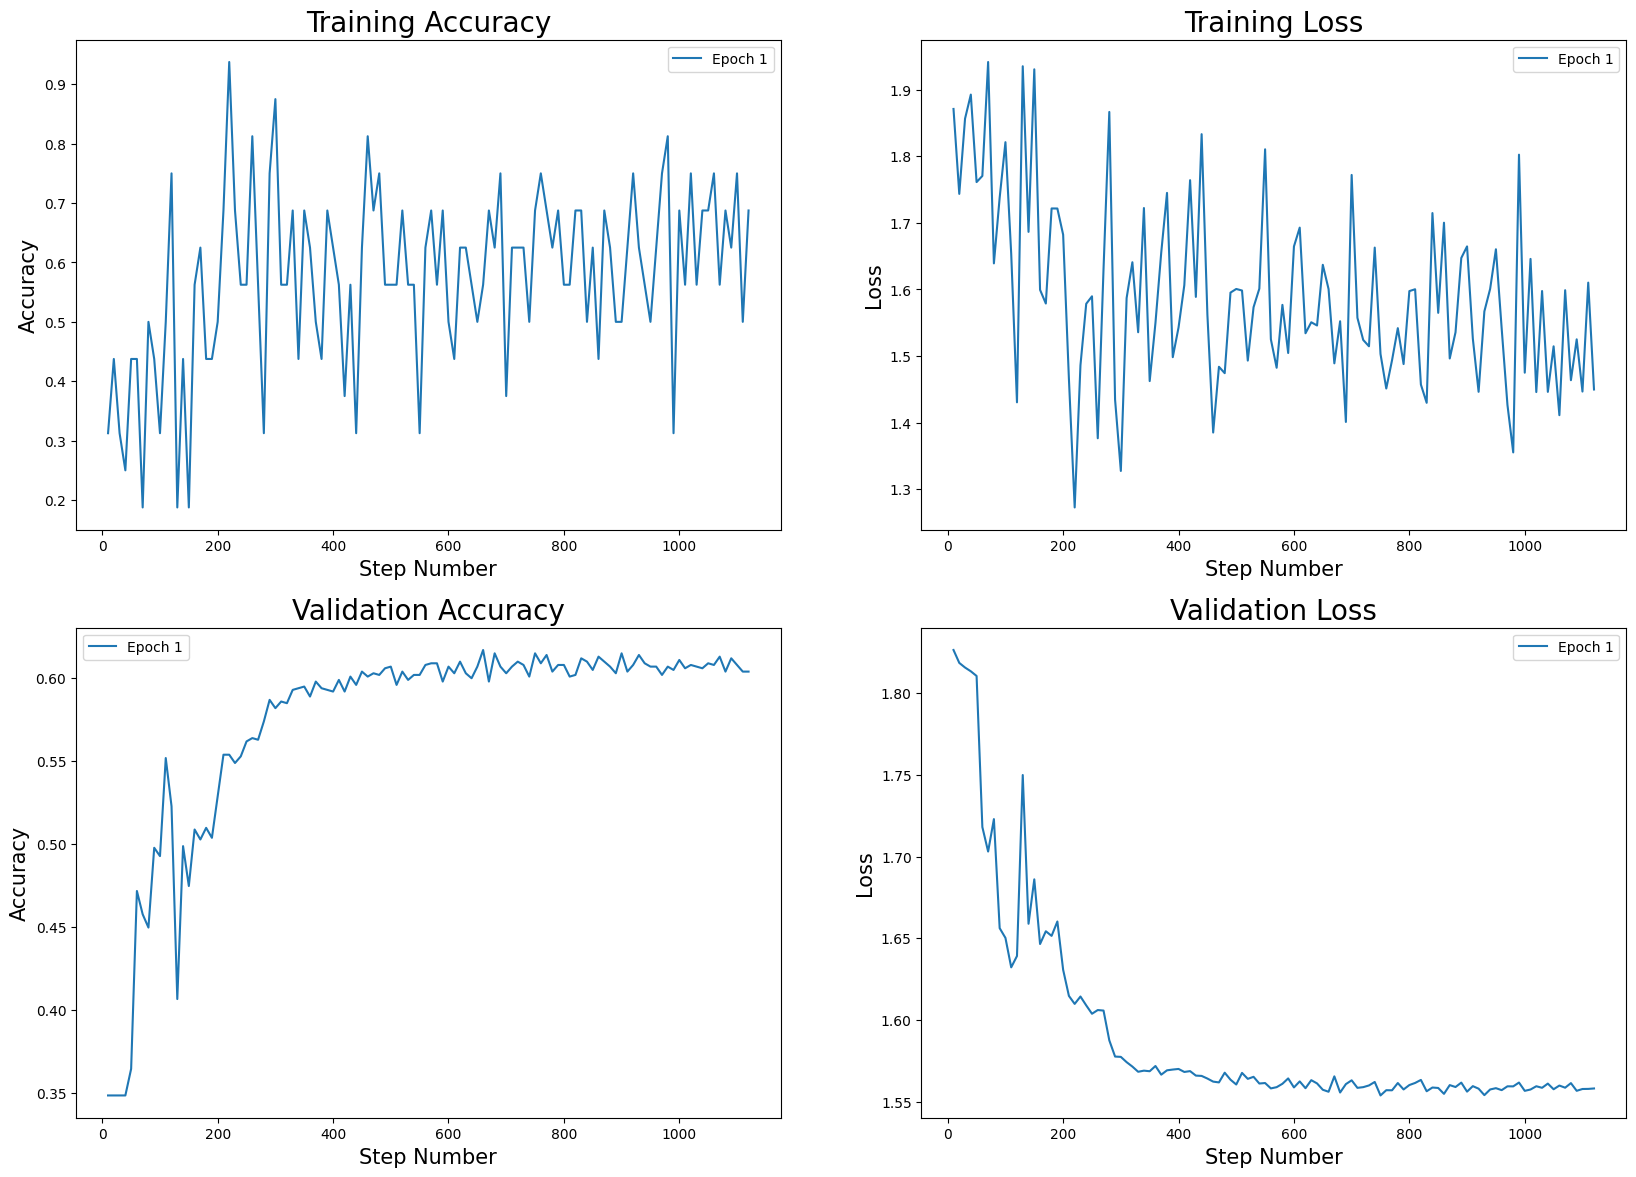

In [135]:
import matplotlib.pyplot as plt
def Acc_Loss_Plot(TA1, TL1, VA1, VL1):
    plt.figure(figsize=(20,14))
    Ac = plt.subplot(2,2,1)
    plt.plot(TA1.keys(), TA1.values())
    #plt.plot(TA2.keys(), TA2.values())
    Ac.set_xlabel("Step Number", fontsize=15)
    Ac.set_ylabel("Accuracy", fontsize=15)
    Ac.set_title("Training Accuracy", fontsize=20)
    Ac.legend(["Epoch 1","Epoch 2"])

    Ls = plt.subplot(2,2,2)
    plt.plot(TL1.keys(), TL1.values())
    #plt.plot(TL2.keys(), TL2.values())
    Ls.set_xlabel("Step Number", fontsize=15)
    Ls.set_ylabel("Loss", fontsize=15)
    Ls.set_title("Training Loss", fontsize=20)
    Ls.legend(["Epoch 1","Epoch 2"])
    
    VAc = plt.subplot(2,2,3)
    plt.plot(VA1.keys(), VA1.values())
    #plt.plot(VA2.keys(), VA2.values())
    VAc.set_xlabel("Step Number", fontsize=15)
    VAc.set_ylabel("Accuracy", fontsize=15)
    VAc.set_title("Validation Accuracy", fontsize=20)
    VAc.legend(["Epoch 1","Epoch 2"])
    
    VLs = plt.subplot(2,2,4)
    plt.plot(VL1.keys(), VL1.values())
    #plt.plot(VL2.keys(), VL2.values())
    VLs.set_xlabel("Step Number", fontsize=15)
    VLs.set_ylabel("Loss", fontsize=15)
    VLs.set_title("Validation Loss", fontsize=20)
    VLs.legend(["Epoch 1","Epoch 2"])

Acc_Loss_Plot(TA[0], TL[0],  VA[0],  VL[0])


**Inference**

In [68]:

import torch

def inference(model, Test_DL):
    
    # Ensure model is in evaluation mode
    model.eval()
    pred = []
    labels = []
    logs = []
    
    for comments, label in Test_DL:
        label = label.to(device)
        label = label.float()
        masks = comments["attention_mask"].squeeze(1).to(device)
        input_ids = comments["input_ids"].squeeze(1).to(device)

    # Perform inference
        with torch.no_grad():
            output = model(input_ids, masks)

    # Extract logits and compute the predicted class index
        logits = output.logits
        logs.append(logits)
        pred_class = torch.argmax(logits, dim=1).item()
        pred.append(pred_class)
        labels.append(label)

    return pred, labels, logs


In [125]:
dft1=pd.read_csv("/kaggle/input/resulttask1/final_task1_time.csv")
evaluate1 = dft1.iloc[:,1]
X_test = pd.DataFrame()
X_test['text'] = evaluate1


In [126]:
X_test

,text
0,Following is the information about Twitter pos...
1,Following is the information about Twitter pos...
2,Following is the information about Twitter pos...
3,Following is the information about Twitter pos...
4,Following is the information about Twitter pos...
...,...
9995,Following is the information about Twitter pos...
9996,Following is the information about Twitter pos...
9997,Following is the information about Twitter pos...
9998,Following is the information about Twitter pos...


In [127]:
X_test

,text
0,Following is the information about Twitter pos...
1,Following is the information about Twitter pos...
2,Following is the information about Twitter pos...
3,Following is the information about Twitter pos...
4,Following is the information about Twitter pos...
...,...
9995,Following is the information about Twitter pos...
9996,Following is the information about Twitter pos...
9997,Following is the information about Twitter pos...
9998,Following is the information about Twitter pos...


In [128]:
from transformers import DistilBertTokenizer
import torch
import numpy as np
from torch.utils.data import DataLoader, Dataset

# Using Pretrained DistilBertTokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Creating Dataset class for Toxic comments with no Labels
class TestToxic_Dataset(Dataset):
    def __init__(self, Comments_):
        self.comments = Comments_.copy()
        self.comments["text"] = self.comments["text"].map(lambda x: tokenizer(x, padding="max_length", truncation=True, return_tensors="pt"))
    
    def __len__(self):
        return len(self.comments)
    
    def __getitem__(self, idx):
        comment = self.comments.loc[idx, "text"]
        return comment


In [129]:
Test_data = TestToxic_Dataset(X_test)
Test_Loader = DataLoader(Test_data, shuffle=False)

In [130]:
import torch

def infer(model, Test_DL):
    
    # Ensure model is in evaluation mode
    model.eval()
    pred = []
    logs = []
    
    for comments in Test_DL:
        masks = comments["attention_mask"].squeeze(1).to(device)
        input_ids = comments["input_ids"].squeeze(1).to(device)

        # Perform inference
        with torch.no_grad():
            output = model(input_ids, masks)

        # Extract logits and compute the predicted class index
        logits = output.logits
        logs.append(logits)
        pred_class = torch.argmax(logits, dim=1).item()
        pred.append(pred_class)

    return pred, logs


In [131]:
pred,logs = infer(Distil_bert,Test_Loader)

In [132]:
print(pred)

[1, 2, 0, 1, 1, 1, 1, 0, 2, 2, 2, 0, 0, 1, 1, 0, 1, 1, 0, 0, 2, 0, 2, 1, 1, 2, 1, 2, 1, 1, 1, 2, 2, 2, 4, 1, 0, 0, 1, 0, 2, 0, 2, 2, 1, 1, 2, 1, 0, 2, 2, 0, 1, 1, 2, 2, 1, 2, 0, 0, 2, 2, 0, 2, 0, 0, 0, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 1, 0, 1, 2, 2, 1, 0, 2, 0, 0, 2, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 2, 1, 0, 1, 0, 4, 1, 2, 2, 0, 1, 2, 2, 2, 1, 1, 0, 1, 1, 2, 4, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 2, 0, 4, 1, 2, 2, 2, 0, 0, 2, 0, 0, 0, 1, 2, 1, 2, 1, 2, 1, 4, 2, 2, 2, 1, 0, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2, 0, 2, 1, 1, 2, 1, 2, 1, 0, 2, 1, 2, 1, 1, 1, 0, 2, 1, 0, 2, 0, 0, 1, 1, 0, 1, 2, 0, 1, 1, 2, 1, 1, 1, 2, 1, 0, 0, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 0, 0, 0, 1, 0, 0, 0, 2, 1, 0, 1, 0, 0, 1, 1, 0, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 0, 2, 1, 1, 0, 1, 2, 0, 2, 2, 1, 0, 2, 2, 1, 0, 2, 2, 0, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 2, 2, 2, 0, 1, 0, 1, 1, 1, 1, 0, 1, 2, 1, 2, 1, 2, 0, 1, 1, 2, 2, 0, 2, 1, 1, 1, 1, 1, 1, 0, 2, 4, 0, 0, 2, 1, 0, 1, 0, 1, 2, 2, 2, 1, 1, 1, 0, 4, 1, 2, 2, 1, 1, 1, 

In [133]:
dft1['bucket']=pred

In [134]:
dft1.to_csv('time_bucket.csv',index=False)

In [ ]:
labels[0]

In [ ]:
gt = []
for i in range(len(labels)):
    label = torch.argmax(labels[i],dim=1).item()
    gt.append(label)

In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(gt, pred)

# Print the accuracy score
print("Accuracy:", accuracy)
